In [26]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%matplotlib inline

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd
import pycomlink.processing.wet_dry.cnn as cnn
import pycomlink.processing.wet_dry.mlp as mlp


import pycomlink as pycml

# Load example data and do preprocessing

We load the example data from one NetCDF file which contains the time series of 500 CMLs over 10 days. If you want to use your own data, e.g. from a CSV file, look at the respective example notebook for how to get started.

In [29]:
data_path = pycml.io.examples.get_example_data_path()

cmls = xr.open_dataset(data_path + '/example_cml_data.nc')
cmls

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) <U3 '0' '1' '2' '3' ... '496' '497' '498' '499'
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) <U9 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) <U1 ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

# Have a quick look at the data of one CML

We store each CML as item of a list because we want to do the processing per CML.

In the plot, note that there are some outliers. These correspond to fill values, which we get rid of in the next step.

In [138]:
cml_list = [cmls.isel(cml_id=i) for i in range(len(cmls.cml_id))]

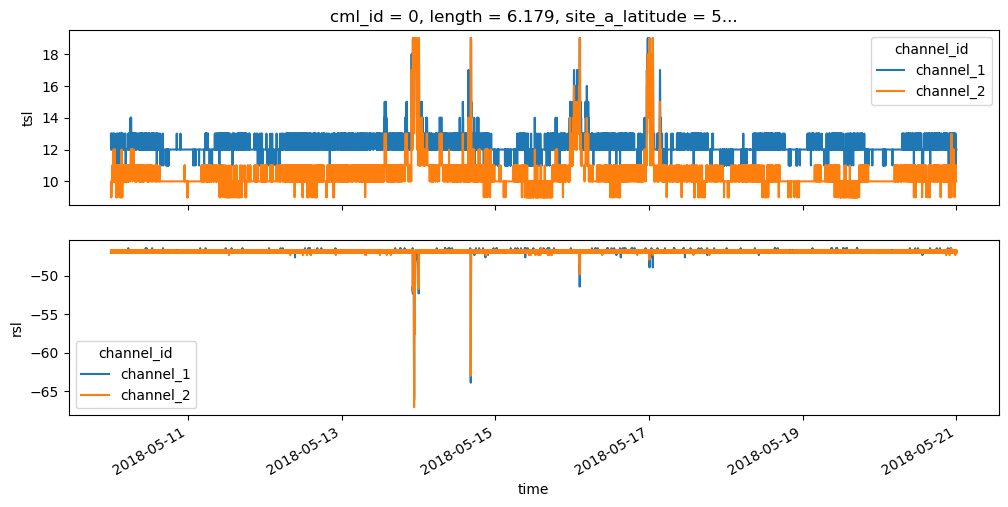

In [139]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,5))
cml_list[0].tsl.plot.line(x='time', ax=axs[0])
cml_list[0].rsl.plot.line(x='time', ax=axs[1])
axs[0].set_xlabel('')
axs[1].set_title('');

# Set default and fill values to NaN and calculate TRSL
TRSL is the transmitted signal level minus the received signal level and represents the total path loss along the CML.

In [140]:
for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl

We can now also see TSL and RSL withouth the fill values that we removed.

Also note that TRSL changes during weak attenuation events stem mostly from TSL changes because this CML has automatic transmission power control (ATPC) which tries to keep RSL constant as long as possible by increasing TSL when path-attenuation occurs.

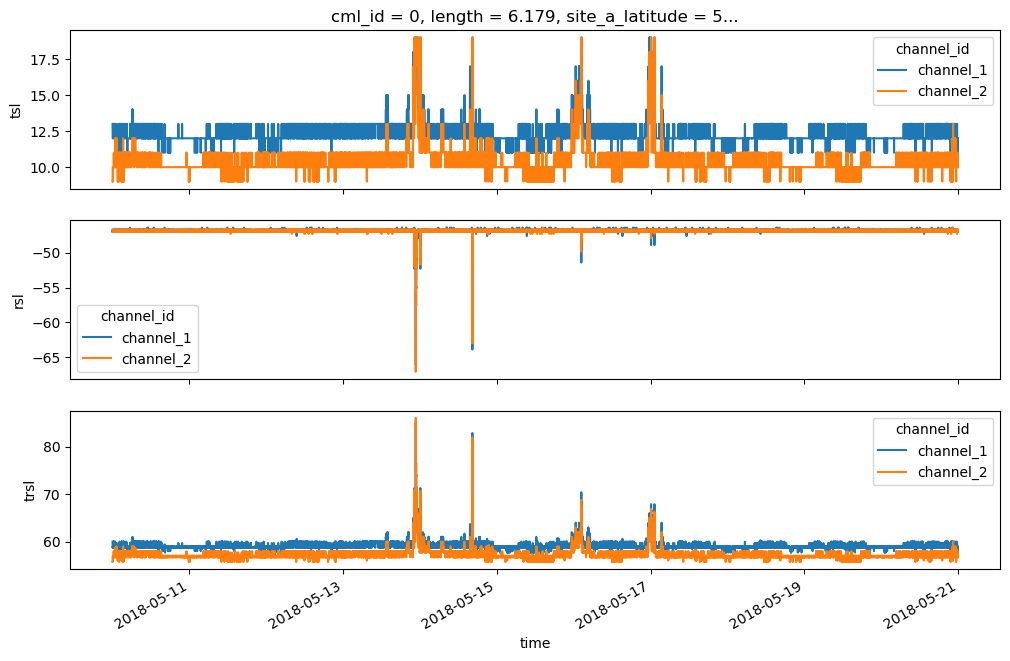

In [141]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7))
cml_list[0].tsl.plot.line(x='time', ax=axs[0])
cml_list[0].rsl.plot.line(x='time', ax=axs[1])
cml_list[0].trsl.plot.line(x='time', ax=axs[2])
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[1].set_title('')
axs[2].set_title('');

# Interpolate short gaps in TRSL 

Our CML data might have data gaps. These gaps can stem from outages of the data acuqisition or from blackout gaps. If they stem from a blackout gap, there are better methods than linear interpolation. See the notebook `Blackout gap detection example` for more details.

Here we stick to a simple linear interpolatoin of a maximum gap width of 5 minutes.

In [142]:
for cml in cml_list:
    cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

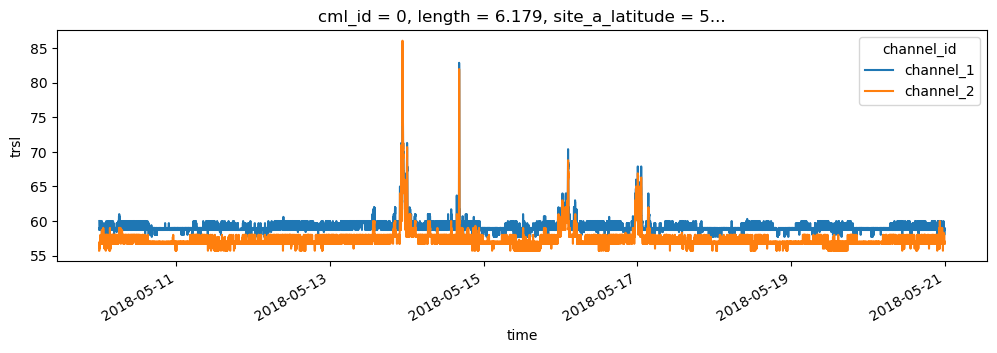

In [143]:
cml = cml_list[0].copy() # make a copy here to not change the CML dataset in the list over which we want to iterate later
cml.trsl.plot.line(x='time', figsize=(12,3));

# Do simple wet-dry classification using different methods

This is the most basic way of doing a wet-dry classification. The crucial part here is to find the optimal threshold. To keep this example short, we use a standard value of 0.8 which is more or less suitable for most CML time series. But please note, that this threshold should be adapted to the noisiness of the individual CML time series, e.g. as in [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020.html) to get the good performance for CML rainfall estimation.

In [144]:
# wet dry classification using rolling standard deviation
threshold = 0.8
roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
cml['wet_rsd'] = ('time', (cml.trsl.isel(channel_id = 0).rolling(time=60, center=True).std() > threshold).values)

# wet dry classification using mlp
mlp_out = mlp.mlp_wet_dry(
    trsl_channel_1 = cml.isel(channel_id = 0).trsl.values,
    trsl_channel_2 = cml.isel(channel_id = 1).trsl.values,
)
cml['wet_mlp'] = ('time', np.argmax(mlp_out, axis = 1).ravel())

# wet dry classification using cnn
cnn_out = cnn.cnn_wet_dry(
    trsl_channel_1 = cml.isel(channel_id = 0).trsl.values,
    trsl_channel_2 = cml.isel(channel_id = 1).trsl.values,
)
cml['wet_cnn'] = ('time', cnn_out > 0.82)


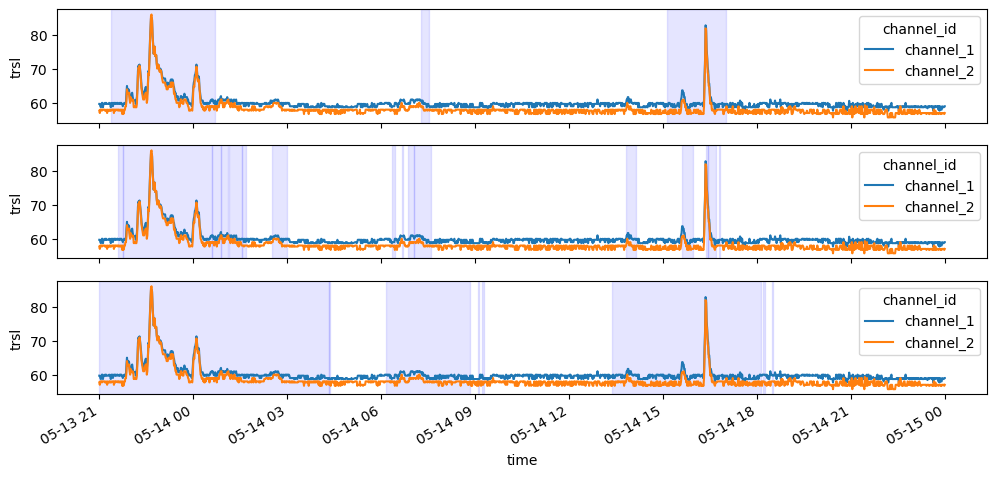

In [145]:
start = '2018-05-13T21'
end = '2018-05-14'
cml_plot = cml.sel(time = slice(start, end))

fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.trsl.plot.line(x='time', ax=axs[0]);
cml_plot.trsl.plot.line(x='time', ax=axs[1]);
cml_plot.trsl.plot.line(x='time', ax=axs[2]);

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_mlp'][0] = 0 
cml_plot['wet_mlp'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp, -1) & ~cml_plot.wet_mlp
wet_end = np.roll(cml_plot.wet_mlp, 1) & ~cml_plot.wet_mlp
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_cnn'][0] = 0 
cml_plot['wet_cnn'][-1] = 0 
wet_start = np.roll(cml_plot.wet_cnn, -1) & ~cml_plot.wet_cnn
wet_end = np.roll(cml_plot.wet_cnn, 1) & ~cml_plot.wet_cnn
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');


# Determine baseline

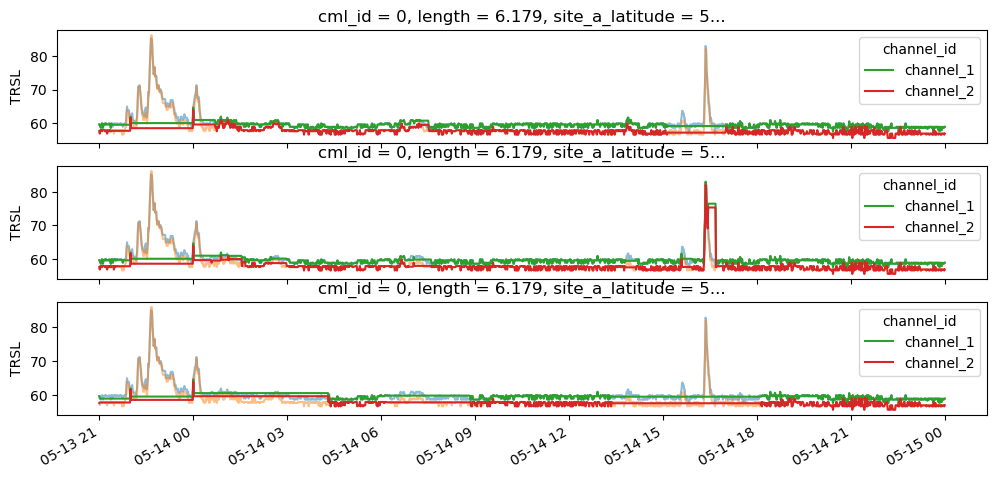

In [88]:
cml['baseline_rsd'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet_rsd, n_average_last_dry=5)
cml['baseline_mlp'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet_mlp, n_average_last_dry=5)
cml['baseline_cnn'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet_cnn, n_average_last_dry=5)

cml_plot = cml.sel(time = slice(start, end))

fig, ax = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.trsl.plot.line(x='time', alpha=0.5, ax=ax[0])
cml_plot.baseline_rsd.plot.line(x='time', ax=ax[0]);
ax[0].set_ylabel('TRSL');
ax[0].set_xlabel('');

cml_plot.trsl.plot.line(x='time', alpha=0.5, ax=ax[1])
cml_plot.baseline_mlp.plot.line(x='time', ax=ax[1]);
ax[1].set_ylabel('TRSL');
ax[1].set_xlabel('');

cml_plot.trsl.plot.line(x='time', alpha=0.5, ax=ax[2])
cml_plot.baseline_cnn.plot.line(x='time', ax=ax[2]);
ax[2].set_ylabel('TRSL');
ax[2].set_xlabel('');

In [94]:
# Thoughts: 

# The MLP is able to identify two peaks at 16:00, but the higher resolution makes it miss the crusial first timesteps in the second peak, resulting in 
# a misplaced baseline. This can be fixed by adding for instance 10 minutes of wet period before MLP wet period. 

# The CNN generally estimates longer periods of wet, this can be beneficial for getting a more stable baseline, but a drawback if the singal is noisy
# as noise above the baseline can be interpreted as rainfall later in the processing. 

# The RSD approach is more robust, but misses some wet events, for instance at 14:00. 

# Perform wet antenna estimation and compare to uncorrected baseline 

In [89]:
cml['waa_rsd'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline_rsd, 
    wet=cml.wet_rsd, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)
cml['waa_mlp'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline_mlp, 
    wet=cml.wet_mlp, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)
cml['waa_cnn'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline_cnn, 
    wet=cml.wet_cnn, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

In [90]:
%matplotlib inline

In [92]:
# estimate WAA and correct baseline
cml['A_rsd'] = cml.trsl - cml.baseline_rsd - cml.waa_rsd
cml['A_rsd'].values[cml.A_rsd < 0] = 0

cml['A_mlp'] = cml.trsl - cml.baseline_mlp - cml.waa_mlp
cml['A_mlp'].values[cml.A_mlp < 0] = 0

cml['A_cnn'] = cml.trsl - cml.baseline_cnn - cml.waa_cnn
cml['A_cnn'].values[cml.A_cnn < 0] = 0

# Calculate rain rate

In [93]:
cml['R_rsd'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A_rsd, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization)
cml['R_mlp'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A_mlp, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization)
cml['R_cnn'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A_cnn, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization)


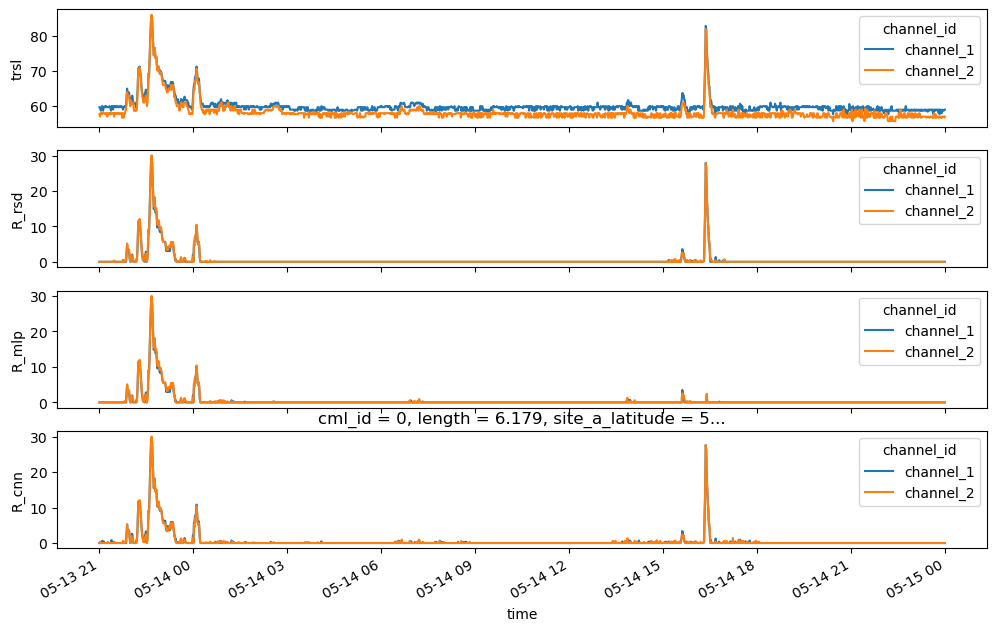

In [102]:
cml_plot = cml.sel(time = slice(start, end))
fig, axs = plt.subplots(4, 1, figsize=(12,7), sharex=True)
cml_plot.trsl.plot.line(x='time', ax=axs[0])

cml_plot.R_rsd.plot.line(x='time', ax=axs[1])
cml_plot.R_mlp.plot.line(x='time', ax=axs[2])
cml_plot.R_cnn.plot.line(x='time', ax=axs[3])


axs[0].set_title('');
axs[0].set_xlabel('');
axs[1].set_title('');
axs[1].set_xlabel('');
axs[2].set_title('');
axs[2].set_xlabel('');

# Example processing many CMLs

In [160]:
# detect outliers and interpolate all CMLs at once
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['trsl'] = cmls.tsl - cmls.rsl
cmls['trsl'] = cmls.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')


In [161]:
# wet dry detection using rsd
cmls['wet_rsd'] = cmls.trsl.rolling(time=60, center=True).std() > 0.8

In [109]:
# wet dry detection using MLP
cmls['wet_mlp'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    mlp_out = mlp.mlp_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).trsl.values,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).trsl.values,
    )
    cmls['wet_mlp'].loc[{'cml_id':cml_id}]=  np.argmax(mlp_out, axis = 1)

 44%|█████████████████▊                      | 222/500 [01:50<02:11,  2.11it/s]/home/erlend/Documents/GitHub/pycomlink/pycomlink/processing/wet_dry/mlp.py:43: RuntimeWarning: Mean of empty slice
  trsl_channel_1_norm = (trsl_channel_1 - np.nanmean(trsl_channel_1)) / np.nanstd(trsl_channel_1)
/home/erlend/anaconda3/envs/pycomlink-devv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erlend/Documents/GitHub/pycomlink/pycomlink/processing/wet_dry/mlp.py:44: RuntimeWarning: Mean of empty slice
  trsl_channel_2_norm = (trsl_channel_2 - np.nanmean(trsl_channel_2)) / np.nanstd(trsl_channel_2)
100%|████████████████████████████████████████| 500/500 [04:04<00:00,  2.05it/s]


In [110]:
# wet dry detection using CNN
cmls['wet_cnn'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    cnn_out = cnn.cnn_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).trsl.values,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).trsl.values,
    )
    cmls['wet_cnn'].loc[{'cml_id':cml_id}]=  cnn_out > 0.82

100%|████████████████████████████████████████| 500/500 [09:03<00:00,  1.09s/it]


### Test that we get the same wet dry as above: 

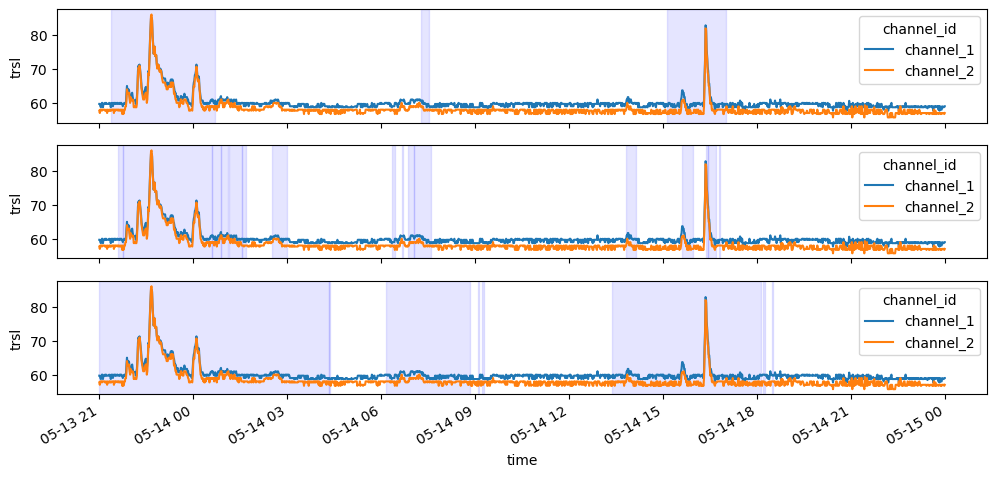

In [162]:
start = '2018-05-13T21'
end = '2018-05-14'
cml_plot = cmls.isel(cml_id = 0).sel(time = slice(start, end))

fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.trsl.plot.line(x='time', ax=axs[0]);
cml_plot.trsl.plot.line(x='time', ax=axs[1]);
cml_plot.trsl.plot.line(x='time', ax=axs[2]);

# shaded rsd
cml_plot['wet_rsd'].loc[{'channel_id':'channel_1'}][0]  = 0 
cml_plot['wet_rsd'].loc[{'channel_id':'channel_2'}][-1]  = 0 
cml_plot['wet_rsd'] = cml_plot['wet_rsd'].astype(bool)
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id = 0).values.nonzero()[0],
    wet_end.isel(channel_id = 0).values.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_mlp'][0] = 0 
cml_plot['wet_mlp'][-1] = 0 
cml_plot['wet_mlp'] = cml_plot['wet_mlp'].astype(bool)
wet_start = np.roll(cml_plot.wet_mlp, -1) & ~cml_plot.wet_mlp
wet_end = np.roll(cml_plot.wet_mlp, 1) & ~cml_plot.wet_mlp
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_cnn'][0] = 0 
cml_plot['wet_cnn'][-1] = 0 
cml_plot['wet_cnn'] = cml_plot['wet_cnn'].astype(bool)
wet_start = np.roll(cml_plot.wet_cnn, -1) & ~cml_plot.wet_cnn
wet_end = np.roll(cml_plot.wet_cnn, 1) & ~cml_plot.wet_cnn
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');
